In [1]:
%env KERAS_BACKEND=tensorflow
%matplotlib inline

env: KERAS_BACKEND=tensorflow


In [102]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import os

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.losses import mean_squared_error
from keras.losses import mean_absolute_percentage_error
from keras.callbacks import TensorBoard

from sklearn import preprocessing
from sklearn import metrics

## Load data

In [4]:
def load_df(src, pattern):
    all_files = glob.glob(os.path.join(src, pattern))
    df = pd.concat([pd.read_csv(f, low_memory=False) for f in all_files], ignore_index=True)

    # minor changes
    df = df.rename(columns={"Time Stamp": "timestamp"})
    df = df.replace("\\N", np.nan)

    # update data types. object is taken as default
    dtypes = dict([(col, np.float64) for col in df.columns])
    dtypes["timestamp"] = "datetime64[ns]"
    df = df.astype(dtypes)

    # change the index to timestamp.
    df.index = df.timestamp
    df = df.drop("timestamp", axis=1)
    
    return df


# load all csv files of North-point site. Concatenate them..
data_src = "../data/insead"
pattern = "*.csv" # don't want to load all data (500MB or more!)
df = load_df(data_src, pattern)

**TODO:** Split the time series into chunks. Each chunk breaks when the field value is null. Train all the chunks separately.

## Data Preparation

In [5]:
def remove_negatives(df, columns=[]):
    columns = columns or df.columns
    for col in columns:
        df.loc[df[col] < 0, col] = 0
    return df

def identify_ct_shutdown(df, ctkw_cols=[], thresh=0.1):
    ctkw_cols = ctkw_cols or [i for i in df.columns if i.startswith("ct") and i.endswith("kw")]
    for col in ctkw_cols:
        df[col + "_shutdown"] = 0
        df.loc[df[col] < thresh, col + "_shutdown"] = 1
    return df

def replace_missing(df, columns=[]):
    columns = columns or df.columns
    rolling_avg = df[columns].rolling(10, min_periods=1).mean()
    df[columns] = df[columns].fillna(rolling_avg).fillna(method="ffill")
    return df

df = remove_negatives(df)
df = identify_ct_shutdown(df)
df = replace_missing(df)

In [6]:
# normalize the data
def get_normalized_df(dataframe, scale=(0,1), columns=[]):
    # columns and index
    columns = columns or dataframe.columns
    index = dataframe.index.values
    
    # fit the scaler
    scaler = preprocessing.MinMaxScaler(scale)
    dataframe = pd.DataFrame(scaler.fit_transform(dataframe), columns=columns, index=index)
    
    # attach the scaler..
    dataframe.scaler = scaler
    return dataframe

df = get_normalized_df(df, scale=(0.1, 1))

In [10]:
# Remove values from the dataframe at beginning so that the
# length is a multiple of batch size. Needed for training.
def equalize_length(arr, batch, where="start"):
    cnt = arr.shape[0]
    return arr[cnt % batch:] if where == "start" else arr[: cnt - (cnt % batch)]
    
# prepare feature vectors. the hypothesis is that
# y(t) can be determined using x1(k), x2(k), x3(k).... for all k = {t-1, t-2, t-3, ... t-N}, where 0 <= N <= t-1
def prepare_features(dataframe, features, target, N=1):
    x, y = [], []
    features_data = dataframe[features].values
    target_data = dataframe[target].values
    
    for i in range(dataframe.shape[0]-N-1):
        x.append(features_data[i:i+N])
        y.append(target_data[i+N])
    
    x = np.array(x)
    y = np.array(y)
    return x, y

# Make features vector 1D & adjust to Keras requirement
shape_x = lambda a: a.reshape((a.shape[0], 1, a.shape[1] * a.shape[2]))
shape_y = lambda a: a.reshape((a.shape[0], 1, 1))

## Take a sample

In [79]:
# manually select training and validaiton data.
batch_size = 200
train_df = df["2017-01-01":"2017-02"]
validation_df = df["2017-03-01":"2017-03-10"]

# The recipe.
features = ["loadsys", "drybulb", "rh", "cwrhdr", "cwsfhdr"]
target = ["cwshdr"]
lookback = 5

# Prepare features and target vectors
train_x, train_y = prepare_features(train_df, features, target, N=lookback)
validation_x, validation_y = prepare_features(validation_df, features, target, N=lookback)
print(train_x.shape, train_y.shape)

# Equalize length
train_x = equalize_length(train_x, batch_size)
train_y = equalize_length(train_y, batch_size)
validation_x = equalize_length(validation_x, batch_size)
validation_y = equalize_length(validation_y, batch_size)

# Reshape to Keras requirements
train_x = shape_x(train_x)
train_y = shape_y(train_y)
validation_x = shape_x(validation_x)
validation_y = shape_y(validation_y)
print(train_x.shape, train_y.shape)

(84754, 5, 5) (84754, 1)
(84600, 1, 25) (84600, 1, 1)


## Prepare model

In [103]:
model = Sequential([
    LSTM(15, batch_input_shape=(batch_size, train_x.shape[1], train_x.shape[2]), stateful=True, return_sequences=True),
    LSTM(10, stateful=True, return_sequences=True),
    Dense(1)
])

model.compile(
    loss=mean_squared_error,
    optimizer="adam",
    metrics=["accuracy", mean_absolute_percentage_error]
)

## Train model

In [ ]:
hist_list = []

for epoch in range(100):
    history = model.fit(
        x=train_x,
        y=train_y,
        batch_size=batch_size,
        verbose=0,
        shuffle=False,
        epochs=1,
        validation_data=(validation_x, validation_y),
        callbacks=[TensorBoard(log_dir="../output/keras2")])
    model.reset_states()
    hist_list.append(history)
    
    if epoch % 50 == 0:
        print("At epoch ", epoch)

At epoch  0


## Metrics

In [64]:
# Test the validation sample...
predicted_y = model.predict(validation_x, batch_size=batch_size) # predict
predicted_y = predicted_y.reshape((predicted_y.shape[0],)) # reshape to normal (Numpy's origin shape)
validation_y = validation_y.reshape((validation_y.shape[0],))

# Inverse scale a particular dimension of the dataset.
def inverse_scale(scaler, col, scaler_idx=0):
    col = col.copy()
    col -= scaler.min_[scaler_idx]
    col /= scaler.scale_[scaler_idx]
    return col

idx = list(df.columns).index(target[0])
inv_validation_y = inverse_scale(df.scaler, validation_y, idx)
inv_predicted_y = inverse_scale(df.scaler, predicted_y, idx)

print("MSE: ", metrics.mean_squared_error(validation_y, predicted_y))
print("MAPE: ", mean_absolute_error_percent(validation_y, predicted_y))

MSE:  0.000218820916394
MAPE:  1.4063996908


## Forecast

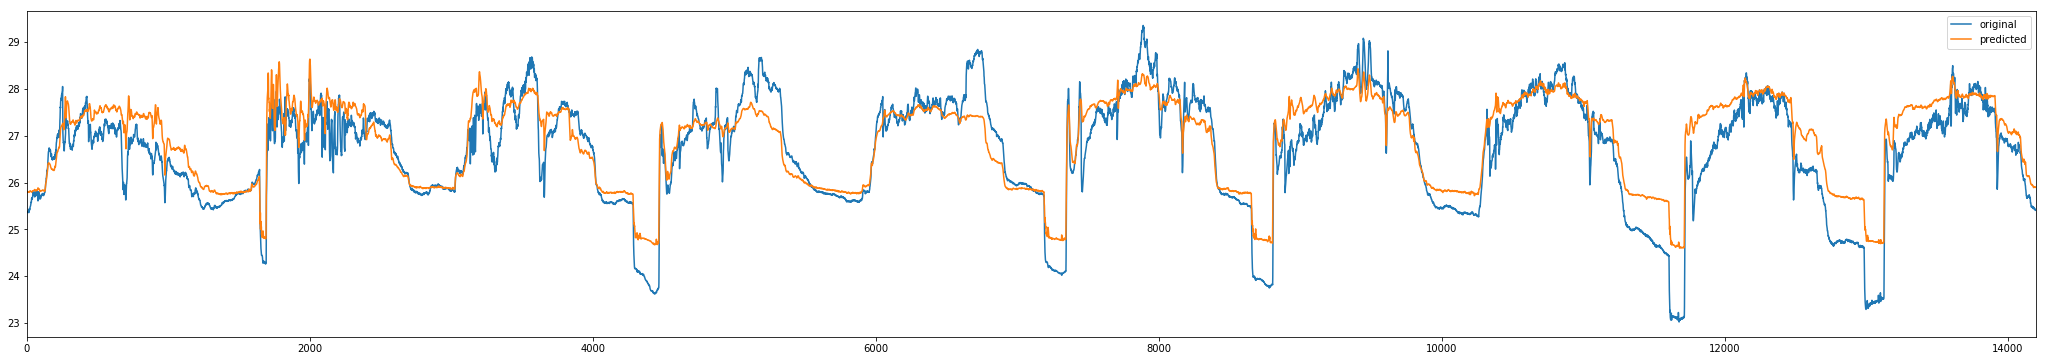

In [78]:
plot_df = pd.DataFrame({"original": inv_validation_y, "predicted": inv_predicted_y})
ax = plot_df.plot(figsize=(36,6))